In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='**********',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\Anuj Khare\Desktop\jupyter_notebook\Data_Analysis_Project\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.4 MB 5.8 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/16.4 MB 5.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.6/16.4 MB 2.3 MB/s eta 0:00:07
   -------- ------------------------------- 3.7/16.4 MB 4.5 MB/s eta 0:00:03
   ------------ --------------------------- 5.2/16.4 MB 5.1 MB/s eta 0:00:03
   ----------------- ---------------------- 7.3/16.4 MB 5.9 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.4 MB 6.9 MB/s eta 0:00:01
   ----------------------------- ---------- 12.1/16.4 MB 7.4 MB/s eta 0:00:01
   ----------------------------------- ---- 14.7/16.4 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.4 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'Anuj@khare',
                             database = 'ecommerce')

cur = db.cursor()

#### List all Unique cities where customers are located.

In [13]:
query = """ select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#### Count the number placed in 2017

In [14]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)

data = cur.fetchall()

print("Total orders placed in 2017 are: ",data[0][0])

Total orders placed in 2017 are:  45101


#### Find the Total sales per category

In [15]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()


df = pd.DataFrame(data)
df.head()

,0,1
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


In [16]:
df = pd.DataFrame(data, columns=['Category','Sales'])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


#### Calculate the percentage of orders that were paid in installments

In [17]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

#### Count the number of Customers from each State.

In [18]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0,1
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852


In [19]:
plt.bar(df['State'], df['Customer_count'])
plt.xticks(rotation=90)
plt.show()

KeyError: 'State'

#### Calculate the number of orders per month in 2018

In [20]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['months', 'order_count'])
df

,months,order_count
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


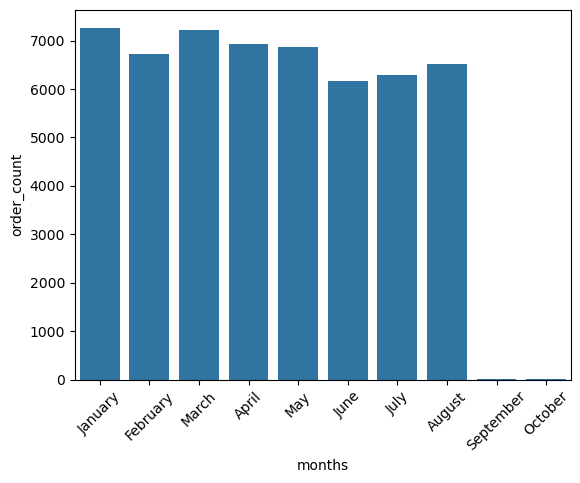

In [21]:
o = ['January','February','March','April','May','June','July','August','September','October']
sns.barplot(x = df['months'], y = df['order_count'], order = o)
plt.xticks(rotation= 45)
plt.show()

#### Find the Average number of products per order, grouped by city.

In [22]:
query = """ WITH count_per_order AS (
    SELECT 
        o.order_id, 
        o.customer_id, 
        COUNT(oi.order_id) AS oc
    FROM ecommerce.orders AS o
    JOIN ecommerce.order_items AS oi
        ON o.order_id = oi.order_id
    GROUP BY 
        o.order_id, 
        o.customer_id
)
SELECT 
    c.customer_city, 
    ROUND(AVG(cpo.oc),2) AS avg_items_per_order
FROM ecommerce.customers AS c
JOIN count_per_order AS cpo
    ON c.customer_id = cpo.customer_id
GROUP BY 
    c.customer_city
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['customer_city', 'average order per product'])
df.head(10)

,customer_city,average order per product
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


#### Calculate the percentage of total revenue contibuted by each product category

In [30]:
query = """select products.product_category category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""

cur.execute(query)

data = cur.fetchall()


df = pd.DataFrame(data, columns=['Categories', 'Percentage distribution'])
df.head()

,Categories,Percentage distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
